# Optotagged FTCs
here we try to create a native python tuning plot, and then try to determine differencese between putative
inhibitory interneurons and pyramidal cells defined by optotagging


In [165]:
import itertools as itt
import pathlib as pl
import joblib as jl
from configparser import ConfigParser

import numpy as np
from scipy.stats import ranksums
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
import seaborn as sns
import joblib as jl

from IPython.display import display

from nems_lbhb.baphy_experiment import  BAPHYExperiment
from nems.epoch import epoch_names_matching
import nems.db as nd
from src.visualization.fancy_plots import  subplots_sqr
from src.metrics.reliability import signal_reliability
from src.root_path import config_path
from src.visualization.fancy_plots import savefig

#### Loads FTC data
right now form a single file
to do, load based on DF querries for neruons

In [166]:

# plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])
plt.style.use(['default', config_path / 'notebook.mplstyle'])

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

# set general parameters for loading and plotting
parmfile = '/auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m'
rasterfs = 1000 # in samps per sec
options ={'recache': False, 'resp': True, 'rasterfs': rasterfs, 'stim':False}


In [210]:
def get_rec(parmfile, rasterfs=1000):
    options ={'recache': True, 'resp': True, 'rasterfs': rasterfs, 'stim':False}
    manager = BAPHYExperiment(parmfile=parmfile)
    rec = manager.get_recording(**options)
    return rec


rec = get_rec(parmfile)

[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 250.38 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb

0 resp


[nems_lbhb.baphy_experiment INFO] Cached recording found


#### works with a whole site at a time
get the response of a neuron to all different tones, sorts the dictionary of tone responses
into an array of shape Repetitions x Neurons x ToneFreq x Time

then parses the important parts of the response, I.E Onset (50ms) Ofsset (50ms) and full duration
(100ms)

mean across repetitions and time (for the time chunck selected, e.g. onset) standard error of the mean over the same numbers



In [211]:
# once you have the recording extract the raw data

def get_tuning_curves(rec, part='all', onset_dur=0.05, offset_dur=0.05, normalize=None, smooth=None):
    rasterfs = rec.meta['rasterfs']
    epochs = rec.epochs
    tone_eps = epoch_names_matching(epochs,'\ASTIM_\d*\Z')
    tone_eps.sort(key= lambda x: int(x.split('_')[1]))
    frequencies = np.asarray([int(t.split('_')[1]) for t in tone_eps])

    resp = rec['resp'].rasterize()
    raster = resp.extract_epochs(tone_eps)

    R, N, T = raster[tone_eps[0]].shape # repetitions, Neurons, time
    S = len(tone_eps)
    site_raster = np.empty((R, N, S, T))

    for ii, key in enumerate(tone_eps):
        site_raster[:, :, ii, :] = raster[key]

    # we need the pre stim silence and sound duration to get different parts of the response parsed out
    PreStimSilence = resp.extract_epoch('PreStimSilence')
    pre_stim_bins = PreStimSilence.shape[-1]
    post_stim_bins = resp.extract_epoch('PostStimSilence').shape[-1]

    if part == 'all':
        raster = site_raster[..., pre_stim_bins :T-post_stim_bins]
    elif part == 'onset':
        raster = site_raster[..., pre_stim_bins : pre_stim_bins + int(onset_dur * rasterfs)]
    elif part == 'offset':
        raster = site_raster[..., T-post_stim_bins : T - post_stim_bins + int(offset_dur * rasterfs)]
    else:
        raise  ValueError

    if normalize == 'zscore':
        raster = (raster - PreStimSilence.mean(axis=(0,-1))[None,:,None,None])\
                 / PreStimSilence.std(axis=(0,-1))[None, :, None, None]
        tuning_curves = raster.mean(axis=(0,-1))
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T)
        spont_rates = np.zeros(N)

    elif normalize == 'real_zscore':
        reference = resp.extract_epoch('REFERENCE')
        raster = (raster - reference.mean(axis=(0,-1))[None,:,None,None])\
                 / reference.std(axis=(0,-1))[None, :, None, None]
        tuning_curves = raster.mean(axis=(0,-1))
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T)
        spont_rates = (PreStimSilence - reference.mean(axis=(0,-1))[None,:,None])\
                      / reference.std(axis=(0,-1))[None, :, None]
        spont_rates = spont_rates.mean(axis=(0,-1))

    elif normalize == 'subdiv':
        spont_rates = PreStimSilence.mean(axis=(0,-1))[:, None]
        tuning_curves = raster.mean(axis=(0,-1))
        max_resp =  tuning_curves.max(axis=1)[:, None]
        tuning_curves = (tuning_curves - spont_rates) / max_resp
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp
        spont_rates = np.zeros(N)

    elif normalize == 'div':
        spont_rates = PreStimSilence.mean(axis=(0,-1))[:, None]
        tuning_curves = raster.mean(axis=(0,-1))
        max_resp =  tuning_curves.max(axis=1)[:, None]
        tuning_curves = tuning_curves / max_resp
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp
        spont_rates = spont_rates / max_resp

    elif normalize == None:
        tuning_curves = raster.mean(axis=(0,-1)) * rasterfs
        SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) * rasterfs
        spont_rates = PreStimSilence.mean(axis=(0, -1)) * rasterfs

    else:
        raise ValueError(f'unknown normalization {normalize}')

    if smooth != None:
        tuning_curves = gaussian_filter1d(tuning_curves, sigma=smooth)


    return tuning_curves, SEMs, spont_rates, frequencies


tuning_curves, SEMs, spont_rates, frequencies = get_tuning_curves(rec, normalize='real_zscore')


#### Plots one example cell
the quality of the plot has been confirmed by comparing with its baphy remote equivalent
there are minor discrepancies but nothing to be worried about.

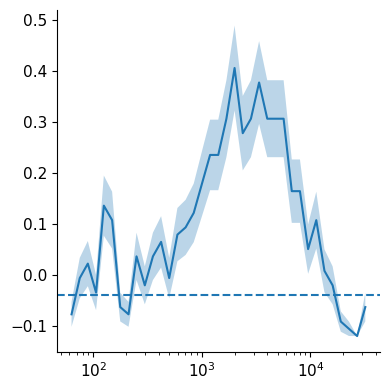

In [212]:
def plot_tuning_curve(tuning_curve, SEM, spont_rate, frequencies, ax=None, logscale=True, **kwargs):

    lower = tuning_curve - SEM
    upper = tuning_curve + SEM

    if ax == None:
        fig, ax = plt.subplots()

    _ = ax.plot(frequencies, tuning_curve, **kwargs)
    _ = ax.fill_between(frequencies, lower, upper, alpha=0.3, **kwargs)
    _ = ax.axhline(spont_rate, linestyle='--', *kwargs)
    if logscale:
        ax.set_xscale('log')
    return ax



# ploting
selected_cells = [rec['resp'].chans[-1]]
fig, axes = subplots_sqr(len(selected_cells), sharex=True, sharey=False)

for ax, cellid in zip(axes, selected_cells):
    cell_idx = rec['resp'].chans.index(cellid)
    _ = plot_tuning_curve(tuning_curves[cell_idx,:], SEMs[cell_idx,:], spont_rates[cell_idx], frequencies, ax=ax)

fig.tight_layout()


### compares normalized vs non normalized tuning curve

<ipython-input-211-ce545919ac4e>:55: RuntimeWarning: divide by zero encountered in true_divide
  tuning_curves = (tuning_curves - spont_rates) / max_resp
<ipython-input-211-ce545919ac4e>:56: RuntimeWarning: invalid value encountered in true_divide
  SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp
<ipython-input-211-ce545919ac4e>:63: RuntimeWarning: invalid value encountered in true_divide
  tuning_curves = tuning_curves / max_resp
<ipython-input-211-ce545919ac4e>:64: RuntimeWarning: invalid value encountered in true_divide
  SEMs = raster.std(axis=(0, -1)) / np.sqrt(R + T) / max_resp
<ipython-input-211-ce545919ac4e>:65: RuntimeWarning: divide by zero encountered in true_divide
  spont_rates = spont_rates / max_resp


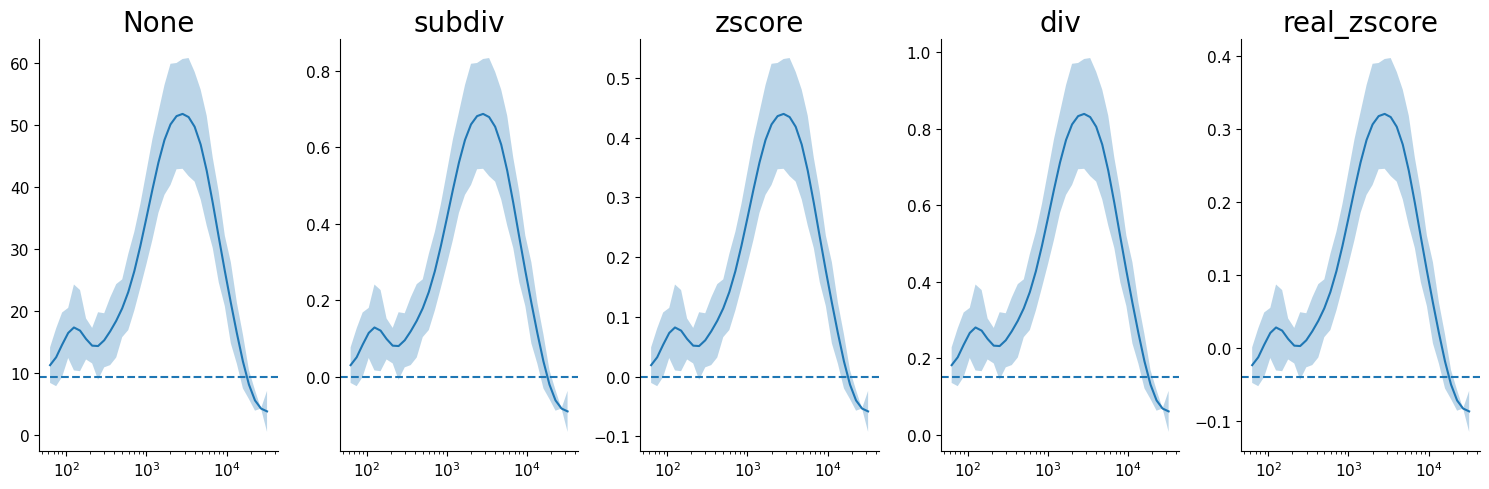

In [213]:
cell_idx = -1

fig, axes = plt.subplots(1,5, figsize=(15,5))

for ax, norm in zip(axes, [None, 'subdiv', 'zscore', 'div', 'real_zscore']):
    tuning_curves, SEMs, spont_rates, frequencies = get_tuning_curves(rec, normalize=norm, smooth=2)
    _ = plot_tuning_curve(tuning_curves[cell_idx,:], SEMs[cell_idx,:], spont_rates[cell_idx], frequencies, ax=ax)
    ax.set_title(str(norm))



# now to quantify
### first define two methods to either re-label frequencies or center and stack tuning curves

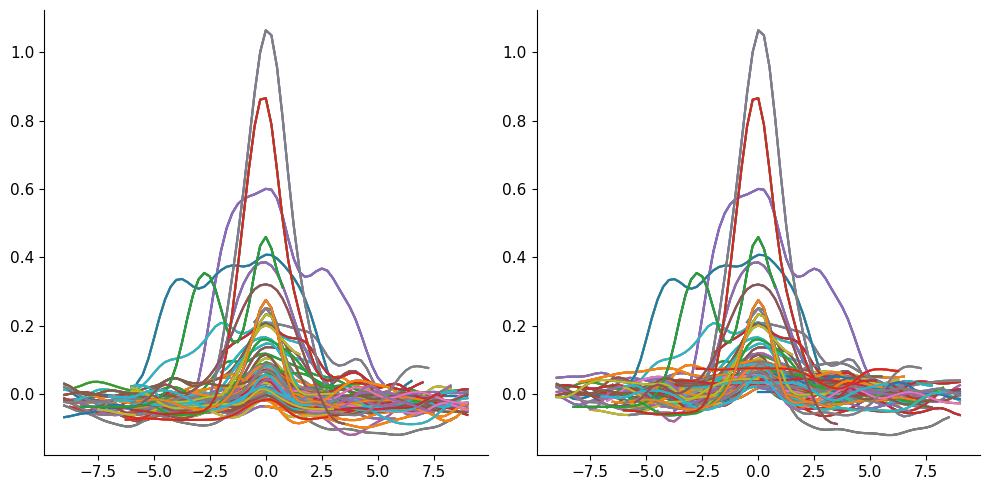

In [214]:
def get_relative_frequency(tuning_curves, frequencies):
    """
    creates a new version of frequencies relative to the tuning max, i.e. best frequencies, and with values in octaves
    relative to this best frequency
    """
    N, S = tuning_curves.shape
    relative_freqs = np.empty((N, S))

    for cc, curve in enumerate(tuning_curves):
        bf_idx = np.argmax(curve)
        relative_freqs[cc,:] = np.log2(frequencies/frequencies[bf_idx])

    return  relative_freqs

def aling_at_bf(tuning_curves, frequencies, negatives=False, flip=False):
    """
    re stacks the tuning curves in a nan paded array, such that all the best frequencies are aligned
    """
    N, S = tuning_curves.shape
    centered_tuning_curves = np.full((N, S*2), np.nan)
    for cc, curve in enumerate(tuning_curves):
        if negatives:
            bf_idx = np.argmax(np.abs(curve))
        else:
            bf_idx = np.argmax(curve)

        if flip:
             if np.abs(np.min(curve)) >  np.max(curve):
                curve = curve * -1

        centered_tuning_curves[cc, S-bf_idx: S*2-bf_idx] = curve

    bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)
    common_rel_freqs = np.linspace(S*-bin_octave_size, S*bin_octave_size, S*2, endpoint=False)

    # if there is extra nan padding across al neurons, removes it
    mask = ~np.all(np.isnan(centered_tuning_curves), axis=0)
    centered_tuning_curves = centered_tuning_curves[:, mask]
    common_rel_freqs = common_rel_freqs[mask]

    return centered_tuning_curves, common_rel_freqs


fig, axes = plt.subplots(1, 2 , figsize=(10,5))

for ax, par in zip(axes, (False, True)):
    centered_tuning_curves, common_rel_freqs = aling_at_bf(tuning_curves, frequencies,
                                                           negatives=par, flip=par)
    _ = ax.plot(common_rel_freqs, centered_tuning_curves.T)
    _ = ax.plot(common_rel_freqs, centered_tuning_curves.T)


In [215]:
best_neu_idx, _ = np.where(tuning_curves == tuning_curves.max())
best_neu_idx = best_neu_idx[0]
print(f'best neuron index: {best_neu_idx}')

best neuron index: 156


### lets calculate the full width at half maximum
this is a quick measure of the broadness of tuning

In [217]:
def full_width_half_max(tuning_curves, frequencies, spont_rates, negatives=False, **kwargs):
    def _fwhm(tuning_curve, frequencies, spont_rate):
        # works with flipped tuning curves if greater suppresion than activity
        if negatives:
            if np.max(tuning_curve) < np.abs(np.min(tuning_curve)):
                tuning_curve = tuning_curve * -1

        # calculates the halfmax as the half delta, since many neurons have a high spont rate
        halfmax = (spont_rate + tuning_curve.max())/2
        max_idx = np.argmax(tuning_curve)
        # special cases when bf is on the edge of tuning curve
        if max_idx == 0:
            left_idx = 0
            right_idx = (tuning_curve[max_idx+1:] < halfmax).argmax() + max_idx + 1
        elif max_idx == len(tuning_curve)-1:
            left_idx = max_idx - (tuning_curve[:max_idx][::-1] < halfmax).argmax() - 1
            right_idx = len(tuning_curve)-1
        else:
            # picks the index of the righmost occurrence of the ~ half max to the left of max idx, excluding the max_idx itself
            left_idx = max_idx - (tuning_curve[:max_idx][::-1] < halfmax).argmax() - 1
            # picks the index of the leftmost occurrence of ~ halfmax to the right of max_idx, excluing max_idx itself.
            right_idx = (tuning_curve[max_idx+1:] < halfmax).argmax() + max_idx + 1

        bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)

        fwhm = (right_idx - left_idx) * bin_octave_size

        return fwhm, np.array([left_idx, right_idx])

    FWHM = np.empty(tuning_curves.shape[0])
    widht_idx = np.empty((tuning_curves.shape[0],2))
    for cc, (curve, spont) in enumerate(zip(tuning_curves, spont_rates)):
        FWHM[cc], widht_idx[cc,:] = _fwhm(curve, frequencies, spont)

    return FWHM, widht_idx.astype(int)

# FWHM, widht_idx = full_width_half_max(tuning_curves, frequencies, spont_rates)
# display(widht_idx[best_neu_idx,0])

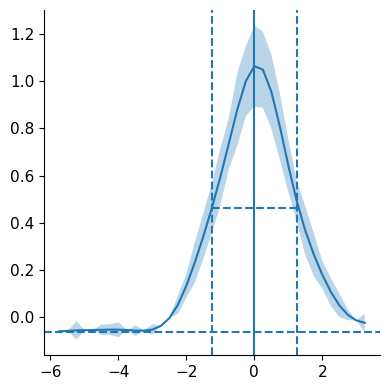

In [219]:
def plot_fwhm(tuning_curve, SEM, spont_rate, frequencies, ax=None, negatives=False, **kwargs):

    FWHM, widht_idx = full_width_half_max(tuning_curve[None,:], frequencies, spont_rate[None], negatives)
    frequencies = get_relative_frequency(tuning_curve[None, :], frequencies)[0, :]

    ax = plot_tuning_curve(tuning_curve, SEM, spont_rate, frequencies, ax=ax, logscale=False, **kwargs)

    if negatives:
        max_idx = np.argmax(np.abs(tuning_curve))
    else:
        max_idx = np.argmax(tuning_curve)

    left_idx, right_idx = widht_idx[0,:]

    ax.axvline(frequencies[max_idx])
    ax.axvline(frequencies[left_idx], linestyle='--')
    ax.axvline(frequencies[right_idx], linestyle='--')
    ax.hlines(tuning_curve[left_idx], frequencies[left_idx], frequencies[right_idx],
                linestyle='--')
    return ax

_ = plot_fwhm(tuning_curves[best_neu_idx,:], SEMs[best_neu_idx,:], spont_rates[best_neu_idx], frequencies)

### alteratively median and integral based calculations
perhaps with some gaussian fitting.

In [220]:
def half_integral(tuning_curves, frequencies, db_plot=False, negatives=False,**kwargs):
    def _half_int(tuning_curve, frequencies):
        # works with flipped tuning curves if greater suppresion than activity
        if negatives:
            if np.max(tuning_curve) < np.abs(np.min(tuning_curve)):
                tuning_curve = tuning_curve * -1

        tuning_curve = tuning_curve - np.min(tuning_curve)
        max_idx = np.argmax(tuning_curve)
        threshold = np.absolute(tuning_curve).sum() / 4
        # special cases when bf is on the edge of tuning curve
        if max_idx == 0:
            left_idx = 0
            right_abs_cum_sum = np.abs(tuning_curve[max_idx+1:]).cumsum() + np.max(tuning_curve) / 2
            right_idx = (right_abs_cum_sum > threshold).argmax() + max_idx + 1 if np.any(right_abs_cum_sum > threshold) else len(tuning_curve) - 1
        elif max_idx == len(tuning_curve)-1:
            left_abs_cum_sum = np.abs(tuning_curve[:max_idx])[::-1].cumsum() + np.max(tuning_curve) / 2
            left_idx = max_idx - (left_abs_cum_sum > threshold).argmax() - 1 if np.any(left_abs_cum_sum > threshold) else 0
            right_idx = len(tuning_curve)-1
        else:
            # picks the index of the rightmost cumsum greater than a 1/4 total tuning curve sum, left of the max
            left_abs_cum_sum = np.abs(tuning_curve[:max_idx])[::-1].cumsum() + np.max(tuning_curve) / 2
            left_idx = max_idx - (left_abs_cum_sum > threshold).argmax() - 1 if np.any(left_abs_cum_sum > threshold) else 0
            # picks the index of the leftmose cumsum greater than a 1/4 total tuning curve sum, right of the max
            right_abs_cum_sum = np.abs(tuning_curve[max_idx+1:]).cumsum() + np.max(tuning_curve) / 2
            right_idx = (right_abs_cum_sum > threshold).argmax() + max_idx + 1 if np.any(right_abs_cum_sum > threshold) else len(tuning_curve) - 1

        bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)
        half_integral = (right_idx - left_idx) * bin_octave_size

        if db_plot:
            normalizer = np.max(tuning_curve) / np.max(np.concatenate([left_abs_cum_sum, right_abs_cum_sum]) )
            fig, ax = plt.subplots()
            ax.plot(frequencies, tuning_curve)
            ax.set_xscale('log')
            ax.axvline(frequencies[max_idx], linestyle='--')
            ax.axhline(threshold * normalizer, linestyle=':', color='white')

            ax.plot(frequencies[:max_idx], left_abs_cum_sum[::-1] * normalizer, color='C1')
            ax.axvline(frequencies[left_idx], linestyle='--', color='C1')

            ax.plot(frequencies[max_idx+1:], right_abs_cum_sum * normalizer, color='C2')
            ax.axvline(frequencies[right_idx], linestyle='--', color='C2')

        return half_integral, np.array([left_idx, right_idx])

    half_integrals = np.empty(tuning_curves.shape[0])
    widht_idx = np.empty((tuning_curves.shape[0],2))
    for cc, curve in enumerate(tuning_curves):
        half_integrals[cc], widht_idx[cc,:] = _half_int(curve, frequencies)

    return half_integrals, widht_idx.astype(int)

# half_integrals, widht_idx = half_integral(tuning_curves[best_neu_idx,:][None,:], frequencies, db_plot=True)
half_integrals, widht_idx = half_integral(tuning_curves, frequencies, db_plot=False)
print(f'half integral: {half_integrals.shape}',
      f'width_idx: {widht_idx.shape}')


half integral: (198,) width_idx: (198, 2)


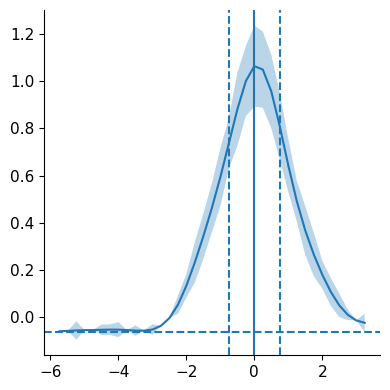

In [221]:
def plot_half_int(tuning_curve, SEM, spont_rate, frequencies, ax=None, negatives=False, **kwargs):

    half_int, widht_idx = half_integral(tuning_curve[None,:], frequencies, db_plot=False, negatives=negatives)
    frequencies = get_relative_frequency(tuning_curve[None, :], frequencies)[0, :]

    ax = plot_tuning_curve(tuning_curve, SEM, spont_rate, frequencies, ax=ax, logscale=False, **kwargs)

    if negatives:
        max_idx = np.argmax(np.abs(tuning_curve))
    else:
        max_idx = np.argmax(tuning_curve)

    left_idx, right_idx = widht_idx[0,:]

    ax.axvline(frequencies[max_idx])
    ax.axvline(frequencies[left_idx], linestyle='--')
    ax.axvline(frequencies[right_idx], linestyle='--')
    return ax
_ = plot_half_int(tuning_curves[best_neu_idx,:], SEMs[best_neu_idx,:], spont_rates[best_neu_idx], frequencies)


# load all sites with optotaging
#### db querry for parameter files

In [222]:
runclass='FTC'
sql="SELECT sCellFile.*,gSingleCell.siteid,gSingleCell.phototag FROM gSingleCell " +\
    "INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid " +\
    "INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid " +\
   f"WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']

#### select sites and parameter files, and parses optotagging values

In [223]:
site_df = d.loc[:, ['siteid', 'parmfile']].drop_duplicates()
display(site_df)
tag_df = d.loc[:, ['cellid', 'phototag', 'siteid']].drop_duplicates()

activated = d.loc[d.phototag == 'a', 'cellid'].unique()
supressed = d.loc[d.phototag == 's', 'cellid'].unique()

print(f'{activated.size} activated, {supressed.size} supressed, {activated.size+supressed.size} total')
print(tag_df.siteid.unique())

,siteid,parmfile
0,TNC017a,/auto/data/daq/Teonancatl/TNC017/TNC017a21_p_F...
74,TNC014a,/auto/data/daq/Teonancatl/TNC014/TNC014a19_p_F...
121,TNC016a,/auto/data/daq/Teonancatl/TNC016/TNC016a20_p_F...
172,TNC015a,/auto/data/daq/Teonancatl/TNC015/TNC015a20_p_F...
196,TNC018a,/auto/data/daq/Teonancatl/TNC018/TNC018a24_p_F...
295,TNC019a,/auto/data/daq/Teonancatl/TNC019/TNC019a20_p_F...


34 activated, 203 supressed, 237 total
['TNC017a' 'TNC014a' 'TNC016a' 'TNC015a' 'TNC018a' 'TNC019a']


#### loads recordins, gets tuning curves, organizes in big array

In [224]:
df_file = pl.Path(config['paths']['analysis_cache']) / '211020_ftc_summary_df'
recache = False
if df_file.exists() and recache == False:
    print(f'DF file found\nloading from {df_file}')
    DF = jl.load(df_file)
else:
    DF = pd.DataFrame()
    for _, row in site_df.iterrows():
        print(row.siteid)
        rec = get_rec(row.parmfile, rasterfs=1000)
        r, _ = signal_reliability(rec['resp'], epoch_names=r'\ASTIM_\d*\Z', threshold=0.01)
        for normalization, smooth, part in itt.product(['zscore'], [1,2], ['all', 'onset']):
            tc, sem, sr, fq = get_tuning_curves(rec, normalize=normalization, smooth=smooth, part=part)
            bf_idx = np.argmax(np.abs(tc), axis=-1)
            for func, fname in zip([full_width_half_max, half_integral], ['FWHM', 'half_int']):
                metric, _ = func(tc, fq, spont_rates=sr, negatives=True)

                df = pd.DataFrame()
                for cc, cellid in enumerate(rec['resp'].chans):
                    df['siteid'] = row.siteid
                    df['cellid'] = cellid
                    df['spont_rate'] = sr[cc]
                    df['response'] = (tc[cc,:], )
                    df['frequency'] = (fq, )
                    df['sem'] = (sem[cc,:], )
                    df['reliability'] = r[cc]
                    df['metric_name'] = fname
                    df['metric_val'] = metric[cc]
                    df['normalization'] = str(normalization)
                    df['smooth'] = 0 if smooth == None else smooth
                    df['part'] = part
                    df['bf_idx'] = bf_idx[cc]
                    df['bf_resp'] = tc[cc, bf_idx[cc]]

                    DF = DF.append(df, ignore_index=True)
    jl.dump(DF, df_file)
    print(f'done, cacheing at {df_file}')


[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.m


TNC017a


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 157.44 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC017/TNC017a21_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[ne

0 resp


[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.m


TNC014a


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 162.92 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a19_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[ne

0 resp


[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.m


TNC016a


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 154.63 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC016/TNC016a20_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[ne

0 resp


[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.m


TNC015a


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 168.56 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC015/TNC015a20_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[ne

0 resp


[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m


TNC018a


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 250.38 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a24_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[ne

0 resp


[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.m


TNC019a


[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 24 trials totaling 183.94 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC019/TNC019a20_p_FTC.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[ne

0 resp
done, cacheing at /home/mateo/code/context_probe_analysis/data/211020_ftc_summary_df


In [225]:
# print(DF.cellid.unique())
print(len(DF.cellid.unique()))


657


In [226]:
merge = pd.merge(DF, tag_df, how='inner', on='cellid', validate='m:1')
display(merge)

activated = merge.loc[merge.phototag == 'a', 'cellid'].unique()
supressed = merge.loc[merge.phototag == 's', 'cellid'].unique()

print(f'{activated.size} activated, {supressed.size} supressed, {activated.size+supressed.size} total')

,siteid_x,cellid,spont_rate,response,frequency,sem,reliability,metric_name,metric_val,normalization,smooth,part,bf_idx,bf_resp,phototag,siteid_y
0,TNC017a,TNC017a-01-8,0.0,"(0.0853198451144084, 0.05284473643743442, 0.04...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.06305039926436061, 0.05161093103515595, 0.0...",0.007585,FWHM,2.50,zscore,1,all,8,0.187829,s,TNC017a
1,TNC017a,TNC017a-01-8,0.0,"(0.0853198451144084, 0.05284473643743442, 0.04...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.06305039926436061, 0.05161093103515595, 0.0...",0.007585,half_int,2.25,zscore,1,all,8,0.187829,s,TNC017a
2,TNC017a,TNC017a-01-8,0.0,"(0.09371049506832141, 0.06261350891731901, 0.0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.05949475668964205, 0.06640470500428836, 5.6...",0.007585,FWHM,1.75,zscore,1,onset,8,0.149837,s,TNC017a
3,TNC017a,TNC017a-01-8,0.0,"(0.09371049506832141, 0.06261350891731901, 0.0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.05949475668964205, 0.06640470500428836, 5.6...",0.007585,half_int,4.75,zscore,1,onset,8,0.149837,s,TNC017a
4,TNC017a,TNC017a-01-8,0.0,"(0.06785649650536131, 0.06788420146092101, 0.0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.06305039926436061, 0.05161093103515595, 0.0...",0.007585,FWHM,2.75,zscore,2,all,8,0.160419,s,TNC017a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,TNC019a,TNC019a-64-1,0.0,"(0.014043370623938756, 0.016047735782597147, 0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.044178724687827416, 0.04417872468782742, 0....",0.007000,half_int,3.00,zscore,1,onset,26,0.182299,s,TNC019a
3148,TNC019a,TNC019a-64-1,0.0,"(0.03375928768886767, 0.03560875062653392, 0.0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.03829198166390785, 0.05829568583571665, 0.0...",0.007000,FWHM,1.25,zscore,2,all,25,0.074227,s,TNC019a
3149,TNC019a,TNC019a-64-1,0.0,"(0.03375928768886767, 0.03560875062653392, 0.0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.03829198166390785, 0.05829568583571665, 0.0...",0.007000,half_int,3.50,zscore,2,all,25,0.074227,s,TNC019a
3150,TNC019a,TNC019a-64-1,0.0,"(0.015564166720593586, 0.014394306855013774, 0...","(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(0.044178724687827416, 0.04417872468782742, 0....",0.007000,FWHM,1.25,zscore,2,onset,26,0.089869,s,TNC019a


34 activated, 202 supressed, 236 total


### plots aligned tuning curves across all cells from all sites

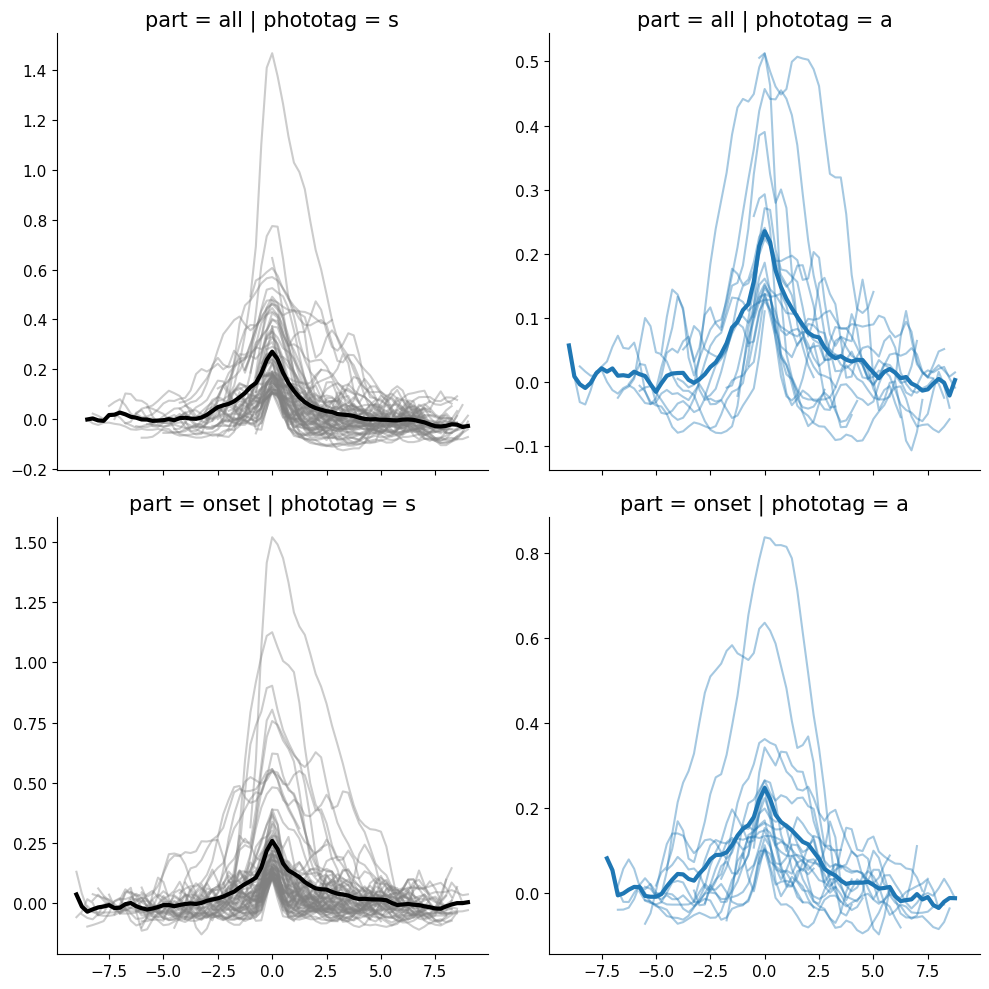

In [240]:
ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_smooth = merge.smooth == 1
ff_part = merge.part.isin(['all', 'onset'])
ff_bfresp = merge.bf_resp > 0.1

toplot = merge.loc[ff_norm & ff_metric & ff_smooth & ff_part & ff_bfresp,
                   ['cellid', 'response', 'frequency', 'phototag', 'part']]
def plot_aligned_tuning(data, **kwargs):
    data = data.sort_values('frequency')
    frequency = np.asarray(data.frequency.unique()[0])
    tuning_curves = np.stack(data['response'].values, axis=0)
    # tuning_curves = data.pivot_table(columns='cellid', index='frequency', values='response').values
    centered_tuning_curves, common_rel_freqs = aling_at_bf(tuning_curves, frequency,
                                                           negatives=True, flip=True)

    ax = plt.gca()

    # sets trial color as gray for clarity
    if isinstance(kwargs['color'], str):
        rgb = mplcolors.hex2color(mplcolors.cnames[kwargs['color']])
    else:
        rgb = kwargs['color']

    if rgb == (0.0, 0.0, 0.0):
        trial_color = 'gray'
    else:
        trial_color = rgb

    ax.plot(common_rel_freqs, centered_tuning_curves.T, color=trial_color, alpha=0.4)
    ax.plot(common_rel_freqs, np.nanmean(centered_tuning_curves, axis=0),
            color=kwargs['color'], linewidth=3)
    return None

g = sns.FacetGrid(toplot, hue='phototag', palette=['black', 'C0'], hue_order=['s', 'a'],
                  col='phototag', col_order=['s', 'a'],
                  row='part', row_order=['all', 'onset'],
                  sharex=True, sharey=False, height=5, aspect=1)
g.map_dataframe(plot_aligned_tuning)

## Poster tuning curves

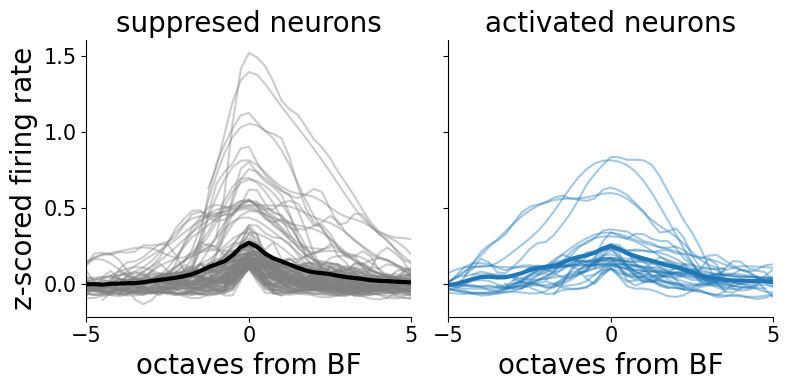

In [239]:
# same as before but ready for poster
ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_smooth = merge.smooth == 1
ff_part = merge.part == 'onset'
ff_bfresp = merge.bf_resp > 0.1

toplot = merge.loc[ff_norm & ff_metric & ff_part & ff_bfresp,
                   ['cellid', 'response', 'frequency', 'phototag']]

g = sns.FacetGrid(toplot, hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'],
                  col='phototag', col_order=['s', 'a'],
                  sharex=True, sharey=True, height=4, aspect=1)
g.map_dataframe(plot_aligned_tuning)
g.set_axis_labels('octaves from BF', 'z-scored firing rate', fontsize=20)
g.set_xticklabels()
axes = g.axes[0]
axes[0].set_title('suppresed neurons', fontsize=20)
axes[1].set_title('activated neurons', fontsize=20)

axes[0].set_xlim([-5,5])
axes[1].set_xlim([-5,5])

axes[0].tick_params(axis='both', labelsize=15)
axes[1].tick_params(axis='both', labelsize=15)

title = 'overlaped_tunint_curves'

# savefig(g.fig, 'SFN_poster', title, type='svg')

### calculates full widht half max

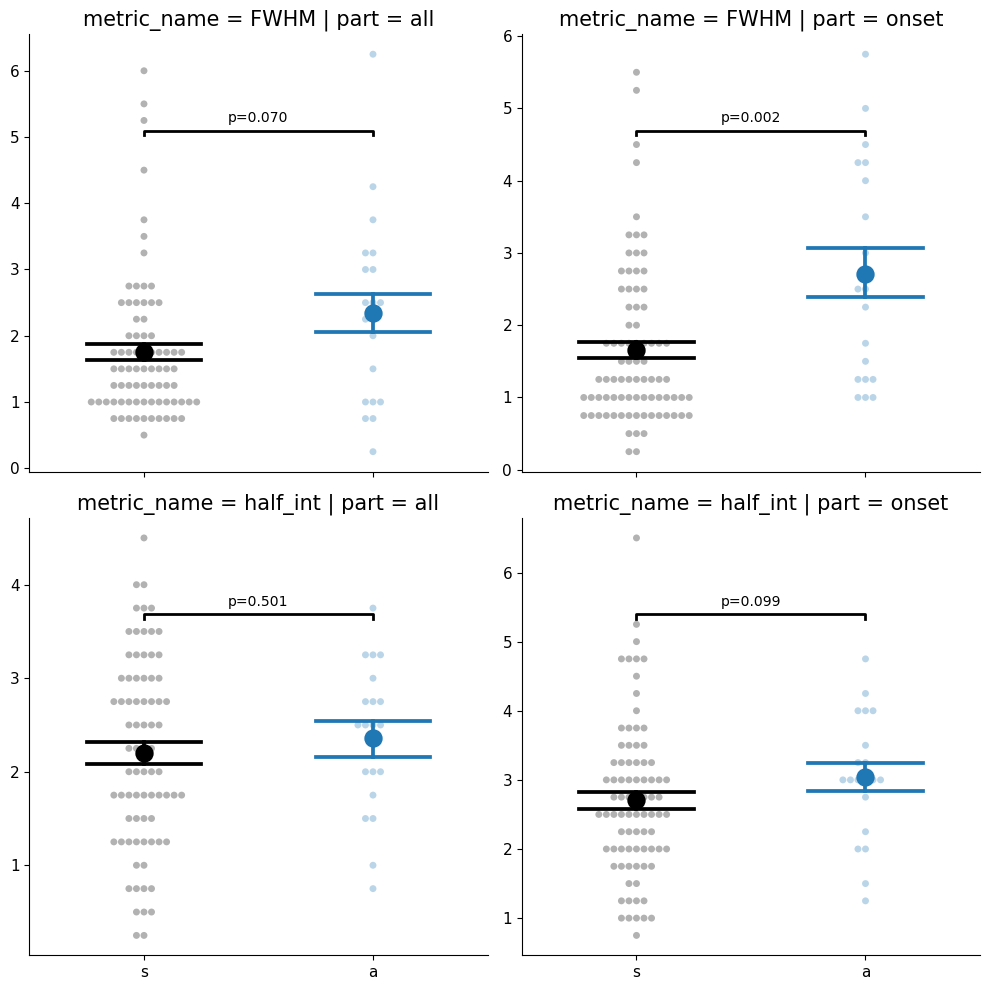

In [238]:
ff_reliable = merge.reliability > -1
ff_smooth = merge.smooth == 1
ff_norm = merge.normalization == 'zscore'
ff_bfresp = merge.bf_resp > 0.1

toplot = merge.loc[ff_reliable & ff_smooth & ff_norm & ff_bfresp,
                    ['cellid', 'reliability', 'metric_val', 'metric_name', 'phototag', 'part']].drop_duplicates()


def add_signif(data ,**kwargs):

    left_vals  = data.loc[data[kwargs['x']] == kwargs['order'][0], kwargs['y']].values
    right_vals  = data.loc[data[kwargs['x']] == kwargs['order'][1], kwargs['y']].values
    stat, pval = ranksums(left_vals, right_vals)

    ax = plt.gca()

    # defines  text position
    y_top, y_bottom = ax.get_ylim()
    ypos = y_bottom + (y_top - y_bottom) * 0.20
    ax.text(0.5, ypos, f'p={pval:.3f}', ha='center')

    # defines lines
    line_y_pos = y_bottom + (y_top - y_bottom) * 0.22
    tick_y_post = line_y_pos + (y_top - y_bottom) * 0.01
    line_x = [0, 0, 1, 1]
    line_y = [tick_y_post, line_y_pos, line_y_pos, tick_y_post]
    ax.plot(line_x, line_y, linewidth=2, color='black')

    return None

g = sns.FacetGrid(toplot, col='part', row='metric_name',
                  sharex=True, sharey=False, height=5, aspect=1)
g.map_dataframe(sns.pointplot, x='phototag', y='metric_val', order =['s', 'a'],
                hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'],
                capsize=0.5, scale=1.5, ci=68)
g.map_dataframe(sns.swarmplot, x='phototag', y='metric_val', order =['s', 'a'],
                hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'], alpha=0.3)
g.map_dataframe(add_signif, x='phototag', y='metric_val', order=['s', 'a'])


## poster summary metrics

In [243]:
ff_smooth = merge.smooth == 1
ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_part = merge.part == 'onset'
ff_bfresp = merge.bf_resp > 0.1
ff_tag = merge.phototag.isin(['s', 'a'])

# display(merge.columns)
metric_df = merge.loc[ff_smooth & ff_norm & ff_metric & ff_part & ff_tag & ff_bfresp,
                    ['cellid', 'metric_val']].drop_duplicates()


resp_df = merge.loc[ff_reliable & ff_smooth & ff_norm & ff_metric & ff_part & ff_tag,
                    ['cellid', 'response']].groupby(['cellid']).max().reset_index()

ff_norm = merge.normalization == 'None'
spont_df = merge.loc[ff_reliable & ff_smooth & ff_norm & ff_metric & ff_part & ff_tag,
                     ['cellid', 'spont_rate', 'phototag']].drop_duplicates()


summary_df = pd.merge(metric_df, resp_df, how='inner', on='cellid', validate='1:1')
summary_df = pd.merge(summary_df, spont_df, how='inner', on='cellid', validate='1:1')
summary_df = summary_df.rename(columns={'metric_val': 'width'})
summary_df = pd.melt(summary_df, id_vars=['cellid', 'phototag'],
                     value_vars=['width', 'response', 'spont_rate'], var_name='metric')




# g = sns.FacetGrid(summary_df, col='metric', col_order=['width', 'spont_rate'],
#                   sharex=True, sharey=False, height=4, aspect=1)
# g.map_dataframe(sns.pointplot, x='phototag', y='value', order =['s', 'a'],
#                 hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'],
#                 capsize=0.4, scale=1, ci=68)
# g.map_dataframe(sns.swarmplot, x='phototag', y='value', order =['s', 'a'],
#                 hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'], alpha=0.4)
# g.map_dataframe(add_signif, x='phototag', y='value', order=['s', 'a'])
#
# g.set_xticklabels(['suppresed', 'activated'], fontsize=15)
#
# axes = g.axes[0]
#
# axes[0].tick_params(axis='both', labelsize=15)
# axes[1].tick_params(axis='both', labelsize=15)
# # axes[2].tick_params(axis='both', labelsize=15)
#
# axes[0].set_ylabel('octaves', fontsize=20)
# axes[1].set_ylabel('firing rate (Hz)', fontsize=20)
# # axes[2].set_ylabel('z-score', fontsize=20)
#
# axes[0].set_title('tuning width', fontsize=20)
# axes[1].set_title('spontaneous activity', fontsize=20)
# # axes[2].set_title('response amplitude', fontsize=20)
#
# title = 'tuning_param_summary'
# savefig(g.fig, 'SFN_poster', title, type='svg')


### what about negative tuning curves??

In [253]:
ff_norm = merge.normalization == 'zscore'
ff_tag = merge.phototag.isin(['a','s'])

responses = merge.loc[ff_norm & ff_tag, ['cellid', 'frequency', 'response','bf_resp']].drop_duplicates().sort_values('bf_resp')
display(responses.head(3))
negcell = responses.cellid.iloc[0]
print(f'most negative cellid {negcell}')

,cellid,frequency,response,bf_resp
2520,TNC019a-04-2,"(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(-0.023530294228907303, 0.005633680175015338, ...",-0.183793
2524,TNC019a-04-2,"(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(-0.000315483630658738, 0.0071436087507418, 0....",-0.179820
2522,TNC019a-04-2,"(63, 75, 89, 106, 125, 149, 177, 211, 250, 298...","(-0.023440782662007248, 0.006955638477374745, ...",-0.161887


most negative cellid TNC019a-04-2


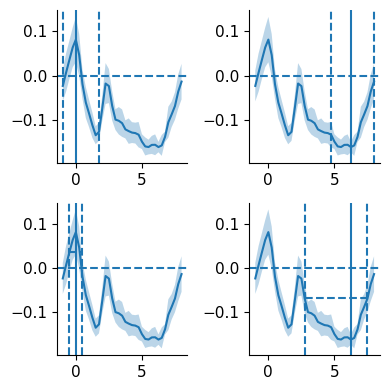

In [254]:
# negcell = 'TNC019a-04-2'
ff_neuron = merge.cellid == negcell
ff_smooth = merge.smooth == 1
ff_norm = merge.normalization == 'zscore'
ff_part = merge.part == 'onset'
ff_metric = merge.metric_name ==  'FWHM'

toplot = merge.loc[ff_neuron & ff_norm & ff_smooth & ff_part & ff_metric, :]
resp = np.asarray(toplot['response'].values[0])
freq = np.asarray(toplot['frequency'].values[0])
sem = np.asarray(toplot['sem'].values[0])
spont = np.asarray(toplot['spont_rate'].values)

# _  = half_integral(resp[None,:], freq, db_plot=True, negatives=True)

fig, axes = plt.subplots(2,2)
_ = plot_half_int(resp, sem, spont, freq, negatives=False, ax=axes[0,0])
_ = plot_half_int(resp, sem, spont, freq, negatives=True, ax=axes[0,1])
_ = plot_fwhm(resp, sem, spont, freq, negatives=False, ax=axes[1,0])
_ = plot_fwhm(resp, sem, spont, freq, negatives=True, ax=axes[1,1])


# tuning plus waveform properties


In [255]:
wf_df_file = pl.Path(config['paths']['analysis_cache']) / '211028_classified_waveform_summary_df'
wf_df = jl.load(wf_df_file)

In [257]:
left = merge.loc[(merge.smooth==1) & (merge.metric_name == 'FWHM') & (merge.normalization == 'zscore'), :]
ftc_wf_df = pd.merge(left, wf_df,
                     how='inner', on=['cellid', 'phototag'], validate='m:1')

In [258]:
def plot_waveforn_cluster(DF):

    sw = DF['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
    ptr = DF['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
    es = DF['es'].values
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values

    X = np.stack((sw, ptr, es), axis=1)
    gmm = GaussianMixture(n_components=2).fit(X)
    labels = gmm.predict(X)
    f, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].scatter(sw[labels == 1], es[labels == 1], s=10)
    ax[0].scatter(sw[labels == 0], es[labels == 0], s=10)
    ax[0].set_xlabel('Spike width (ms)')
    ax[0].set_ylabel('Endslope')
    ax[0].set_title(f"Group 1: {sum(labels == 1)}, Group 2: {sum(labels == 0)}")

    ax[1].scatter(sw[labels == 1], ptr[labels == 1], s=10)
    ax[1].scatter(sw[labels == 0], ptr[labels == 0], s=10)
    ax[1].set_xlabel('Spike width (ms)')
    ax[1].set_ylabel('Peak-trough ratio')

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])

        if labels[w] == 0:
            color = 'moccasin'
        else:
            color = 'tab:blue'
        centered.append(wave)
        ax[2].plot(time, wave, color=color, alpha=0.4)

    ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
    ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

    # categorize as NS / RS -- force Narrow to be label==1
    if sw[labels == 1].mean() < sw[labels == 0].mean():
        ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
    else:
        ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

    f.tight_layout()

    plt.show()
    return ax


def plot_aligned_waveforms(data, ax=None, **kwargs):
    wf = data['waveform_norm'].values
    trough = data['trough'].values

    # sets trial color as gray for clarity
    if isinstance(kwargs['color'], str):
        rgb = mplcolors.hex2color(mplcolors.cnames[kwargs['color']])
    else:
        rgb = kwargs['color']

    if rgb == (0.0, 0.0, 0.0):
        trial_color = 'gray'
    else:
        trial_color = rgb

    if ax is None:
        ax = plt.gca()

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])

        centered.append(wave)
        ax.plot(time, wave, color=trial_color, alpha=0.4)

    centered = np.stack(centered, axis=0)

    ax.plot(time, centered.mean(axis=0), color=rgb, lw=3, zorder=500)


def get_aligned_waveforms(DF):
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])
        centered.append(wave)

    centered = np.stack(centered, axis=0)

    return centered, time


def get_aligned_tunings(DF):

    data = DF.sort_values('frequency')
    assert data.duplicated(subset='cellid').any() == False
    frequency = np.asarray(data.frequency.unique()[0])
    tuning_curves = np.stack(data['response'].values, axis=0)
    centered_tuning_curves, common_rel_freqs = aling_at_bf(tuning_curves, frequency)

    return centered_tuning_curves, common_rel_freqs

Index(['siteid_x', 'cellid', 'spont_rate', 'response', 'frequency', 'sem',
       'reliability', 'metric_name', 'metric_val', 'normalization', 'smooth',
       'part', 'bf_idx', 'bf_resp', 'phototag', 'siteid_y', 'sw', 'ptr',
       'fwhm', 'es', 'bs', 'trough', 'waveform', 'waveform_norm', 'isolation',
       'spike_type'],
      dtype='object')

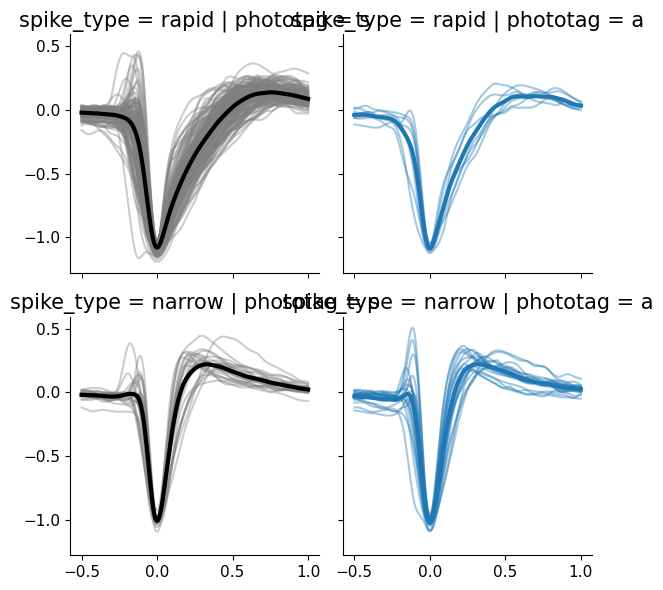

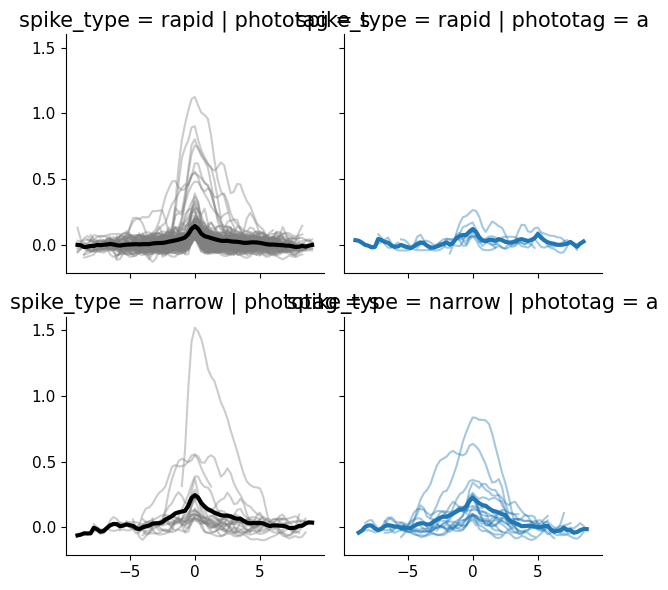

In [259]:
ff_part = ftc_wf_df.part == 'onset'
display(ftc_wf_df.columns)
toplot = ftc_wf_df.loc[ff_part, :].dropna(subset=['sw', 'ptr', 'es', 'waveform_norm', 'phototag'])
# display(toplot)
# plot_aligned_tuning(toplot, color='black')
# plot_aligned_waveforms(toplot, color='black')


g = sns.FacetGrid(toplot, col='phototag', col_order=['s', 'a',],
                  hue='phototag', hue_order=['s','a'], palette=['black', 'C0'],
                  row='spike_type', row_order=['rapid', 'narrow'])
g.map_dataframe(plot_aligned_waveforms)

g = sns.FacetGrid(toplot, col='phototag', col_order=['s', 'a',],
                  hue='phototag', hue_order=['s','a'], palette=['black', 'C0'],
                  row='spike_type', row_order=['rapid', 'narrow'])
g.map_dataframe(plot_aligned_tuning)

full scatter with slected FTC Neurons

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/waveform_tuning_relation.svg
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/waveform_tuning_relation.png


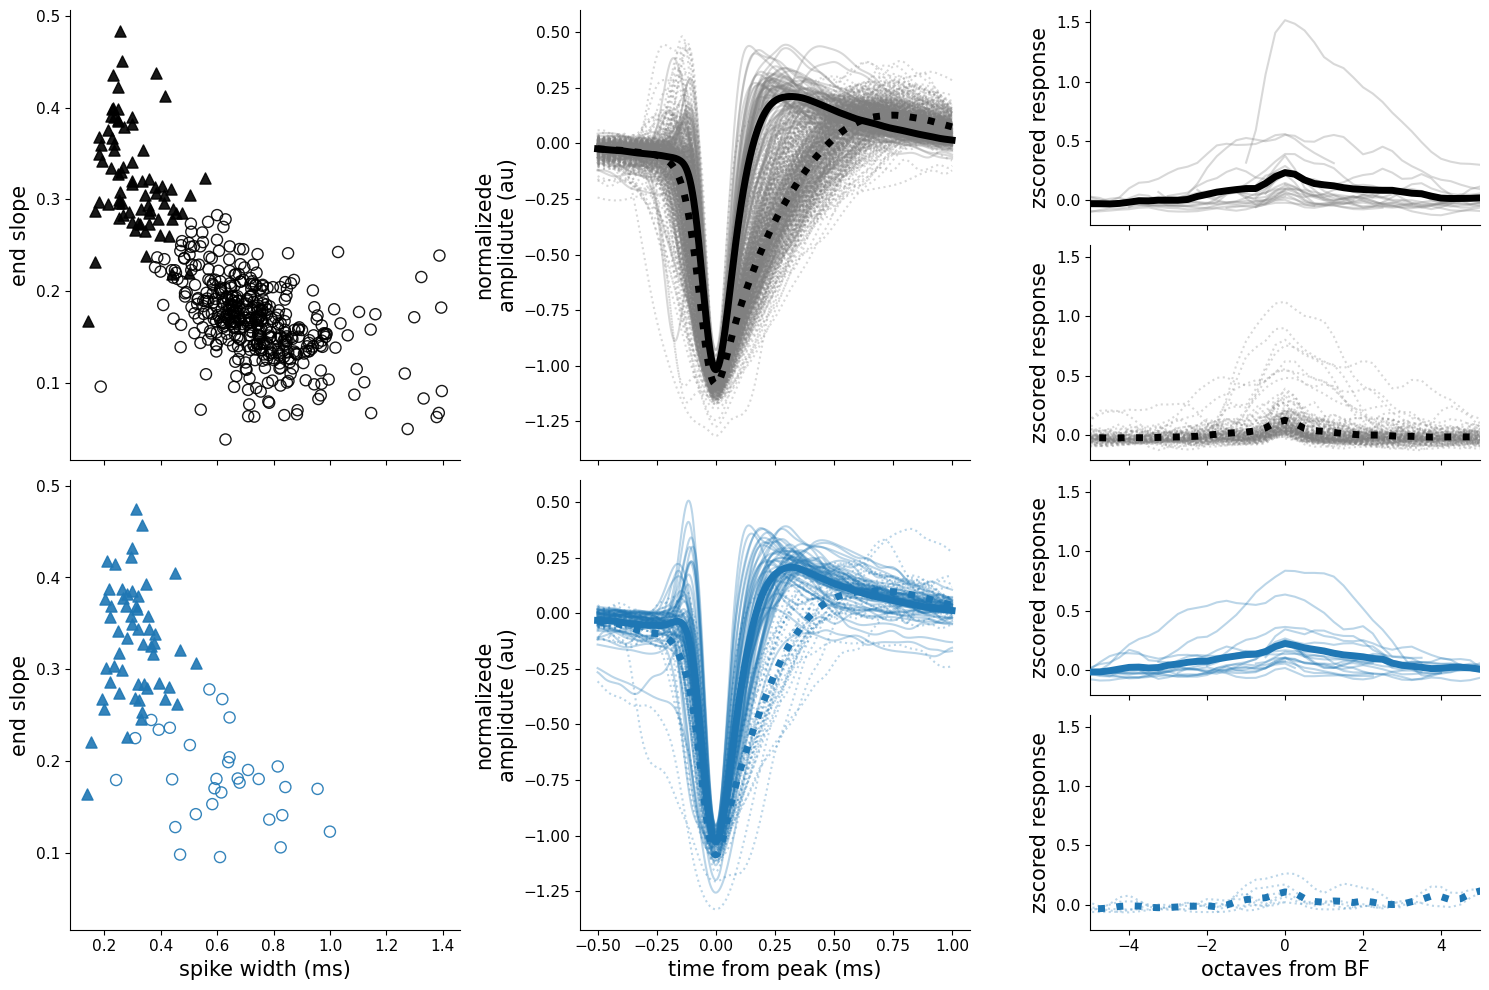

In [260]:
ff_act = wf_df.phototag == 'a'
ff_sup = wf_df.phototag == 's'
ff_rapid  = wf_df.spike_type == 'rapid'
ff_narrow  = wf_df.spike_type == 'narrow'

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(4, 3)


# left side scatters
ax0 = fig.add_subplot(gs[:2,0])
x = wf_df.loc[ff_sup & ff_rapid, 'sw']
y = wf_df.loc[ff_sup & ff_rapid, 'es']
_ = ax0.scatter(x, y, facecolors='none', edgecolors='black', marker='o', alpha=0.9)

x = wf_df.loc[ff_sup & ff_narrow, 'sw']
y = wf_df.loc[ff_sup & ff_narrow, 'es']
_ = ax0.scatter(x, y, color='black', marker='^', alpha=0.9)
plt.setp(ax0.get_xticklabels(), visible=False)
_ = ax0.set_ylabel('end slope')

ax1 = fig.add_subplot(gs[2:,0], sharex=ax0, sharey=ax0)
x = wf_df.loc[ff_act & ff_rapid, 'sw']
y = wf_df.loc[ff_act & ff_rapid, 'es']
_ = ax1.scatter(x, y, facecolors='none', edgecolors='C0', marker='o', alpha=0.9)

x = wf_df.loc[ff_act & ff_narrow, 'sw']
y = wf_df.loc[ff_act & ff_narrow, 'es']
_ = ax1.scatter(x, y, color='C0', marker='^', alpha=0.9)
_ = ax1.set_xlabel('spike width (ms)')
_ = ax1.set_ylabel('end slope')

# centere waveforms
ax2 = fig.add_subplot(gs[:2,1])
y, x = get_aligned_waveforms(wf_df.loc[ff_sup & ff_rapid, :])
_ = ax2.plot(x, y.T, linestyle=':', color='grey', alpha=0.3)
_ = ax2.plot(x, y.mean(axis=0), linestyle=':', color='black', linewidth=5, zorder=500)

y, x = get_aligned_waveforms(wf_df.loc[ff_sup & ff_narrow, :])
_ = ax2.plot(x, y.T, linestyle='-', color='gray', alpha=0.3)
_ = ax2.plot(x, y.mean(axis=0), linestyle='-', color='black', linewidth=5, zorder=500)
plt.setp(ax2.get_xticklabels(), visible=False)
_ = ax2.set_ylabel('normalizede\namplidute (au)')

ax3 = fig.add_subplot(gs[2:,1], sharex=ax2, sharey=ax2)
y, x = get_aligned_waveforms(wf_df.loc[ff_act & ff_rapid, :])
_ = ax3.plot(x, y.T, linestyle=':', color='C0', alpha=0.3)
_ = ax3.plot(x, y.mean(axis=0), linestyle=':', color='C0', linewidth=5, zorder=500)

y, x = get_aligned_waveforms(wf_df.loc[ff_act & ff_narrow, :])
_ = ax3.plot(x, y.T, linestyle='-', color='C0', alpha=0.3)
_ = ax3.plot(x, y.mean(axis=0), linestyle='-', color='C0', linewidth=5, zorder=500)
_ = ax3.set_xlabel('time from peak (ms)')
_ = ax3.set_ylabel('normalizede\namplidute (au)')


# rightsiede tunings

ff_part = ftc_wf_df.part == 'onset'
ff_reliable = ftc_wf_df.reliability >= 0.01
toplot = ftc_wf_df.loc[ff_part, :].dropna(subset=['sw', 'ptr', 'es', 'waveform_norm', 'phototag'])

ff_act = toplot.phototag == 'a'
ff_sup = toplot.phototag == 's'
ff_rapid  = toplot.spike_type == 'rapid'
ff_narrow  = toplot.spike_type == 'narrow'


ax4 = fig.add_subplot(gs[0,2])
y, x = get_aligned_tunings(toplot.loc[ff_sup & ff_narrow, :])
_ = ax4.plot(x, y.T, linestyle='-', color='grey', alpha=0.3)
_ = ax4.plot(x, np.nanmean(y, axis=0), linestyle='-', color='black', linewidth=5, zorder=500)
_ = ax4.set_ylabel('zscored response')
plt.setp(ax4.get_xticklabels(), visible=False)
_ = ax4.set_xlim([-5,5])

ax5 = fig.add_subplot(gs[1,2], sharex=ax4, sharey=ax4)
y, x = get_aligned_tunings(toplot.loc[ff_sup & ff_rapid, :])
_ = ax5.plot(x, y.T, linestyle=':', color='grey', alpha=0.3)
_ = ax5.plot(x, np.nanmean(y, axis=0), linestyle=':', color='black', linewidth=5, zorder=500)
_ = ax5.set_ylabel('zscored response')
plt.setp(ax5.get_xticklabels(), visible=False)

ax6 = fig.add_subplot(gs[2,2], sharex=ax4, sharey=ax4)
y, x = get_aligned_tunings(toplot.loc[ff_act & ff_narrow, :])
_ = ax6.plot(x, y.T, linestyle='-', color='C0', alpha=0.3)
_ = ax6.plot(x, np.nanmean(y, axis=0), linestyle='-', color='C0', linewidth=5, zorder=500)
_ = ax6.set_ylabel('zscored response')
plt.setp(ax6.get_xticklabels(), visible=False)

ax7 = fig.add_subplot(gs[3,2], sharex=ax4, sharey=ax4)
y, x = get_aligned_tunings(toplot.loc[ff_act & ff_rapid, :])
_ = ax7.plot(x, y.T, linestyle=':', color='C0', alpha=0.3)
_ = ax7.plot(x, np.nanmean(y, axis=0), linestyle=':', color='C0', linewidth=5, zorder=500)
_ = ax7.set_xlabel('octaves from BF')
_ = ax7.set_ylabel('zscored response')

title = 'waveform_tuning_relation'
savefig(fig, 'SFN_poster', title, type='svg')
savefig(fig, 'SFN_poster', title, type='png', transparent=False)